In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import json
import csv
import random

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense, Add, Dropout, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

## Deep Learning Based Recommender System
- There are Two (2) parts to approach building a recommender system: <br>
<b> Part-1: </b> Upsell/Cross-sell for Existing Users <br>
<b> Part-2: </b> New Users (what products to recommend) <br> <br>
- <b> Kaggle Dataset used: </b> <br> https://www.kaggle.com/snap/amazon-fine-food-reviews (Main dataset for Part-1 and 2), <br>https://www.kaggle.com/c/santander-customer-transaction-prediction (Supplementary dataset for Part-2) <br>

<i> By: Ivana </i>


In [3]:
#####################
# Loading Dataset
#####################
df = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')

In [4]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [5]:
print ("Total # of rows in dataset:", len(df))
print ("Score:", df.Score.unique()) ## Rating
print ("No. of Product ID:", len(df.ProductId.unique())) ## ProductId
print ("No. of User ID:", len(df.UserId.unique())) ## UserId

Total # of rows in dataset: 568454
Score: [5 1 4 2 3]
No. of Product ID: 74258
No. of User ID: 256059


In [6]:
#####################
# Data Preprocessing
#####################

## Map UserId and ProductId to idx number (0,1,2,...)
users = df.UserId.unique()
products = df.ProductId.unique()

userid2idx = {item:idx for idx, item in enumerate(users)}
idx2userid = {idx:item for idx, item in enumerate(users)}
productid2idx = {item:idx for idx, item in enumerate(products)}
idx2productid = {idx:item for idx, item in enumerate(products)}

df['ProductId_idx'] = df.ProductId.apply(lambda x: productid2idx[x]) ## convert ProductId to ProductId_idx
df['UserId_idx'] = df.UserId.apply(lambda x: userid2idx[x]) ## convert UserId to UserId_idx

## Create user_min, user_max, product_min, product_max, n_users, n_products

user_min, user_max, product_min, product_max = (df.UserId_idx.min(), df.UserId_idx.max(), df.ProductId_idx.min(), df.ProductId_idx.max())
n_users = df.UserId.nunique()
n_products = df.ProductId.nunique()

print (user_min, user_max, product_min, product_max)
print ("No. of unique users: ", n_users, "\n", "No, of unique products:", n_products)
print ("--------")
## Create Train Test Split
df_train, df_valid = train_test_split(df, test_size=0.2)
print ("len(df_train):", len(df_train), "\n", "len(df_valid)", len(df_valid))

0 256058 0 74257
No. of unique users:  256059 
 No, of unique products: 74258
--------
len(df_train): 454763 
 len(df_valid) 113691


In [7]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProductId_idx,UserId_idx
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0,0


## Part-1 : Upsell/Cross-sell Products for Existing Users

In [8]:
########################################################
# 1A - Train NN (Recommender model for Existing User)
########################################################

## Parameters
embedding_dim = 50
np.random.seed = 42
batch_sizes = 64
num_epochs = 50


## Define NN layer
user_input = Input(shape=(1,), dtype='int64', name='user_input')
product_input = Input(shape=(1,), dtype='int64', name='product_input')
emb_user = Embedding(n_users, embedding_dim, input_length=1, embeddings_regularizer=regularizers.l2(1e-4))(user_input)
emb_product = Embedding(n_products, embedding_dim, input_length=1, embeddings_regularizer=regularizers.l2(1e-4))(product_input)
X = Concatenate()([emb_user, emb_product])
X = Flatten()(X)
X = Dense(256, activation='relu')(X) ##1
X = Dropout(0.3)(X)
X = Dense(512, activation='relu')(X) ##2
X = Dropout(0.3)(X)
X = Dense(1024, activation='relu')(X) ##3
X = Dropout(0.3)(X)
X = Dense(64, activation='relu')(X) ##4
X = Dropout(0.5)(X)
X = Dense(1, activation='linear')(X)                     
recommender_model_EU = Model(inputs=[user_input, product_input], outputs=X)                    


## Define loss and optimizer
recommender_model_EU.compile(loss='mse', optimizer=Adam(0.0001))

recommender_model_EU.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
product_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        12802950    user_input[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        3712900     product_input[0][0]              
__________________________________________________________________________________________________
concatenat

In [9]:
## Train Model
recommender_model_EU.fit([df_train.UserId_idx, df_train.ProductId_idx], df_train.Score, batch_size=batch_sizes, epochs=num_epochs, 
          validation_data=([df_valid.UserId_idx, df_valid.ProductId_idx], df_valid.Score), verbose=1)


Train on 454763 samples, validate on 113691 samples
Epoch 1/50
454763/454763 [==============================] - 101s 223us/step - loss: 232.1847 - val_loss: 58.2068
Epoch 2/50
454763/454763 [==============================] - 98s 215us/step - loss: 20.5839 - val_loss: 6.2190
Epoch 3/50
454763/454763 [==============================] - 98s 215us/step - loss: 4.8352 - val_loss: 3.7384
Epoch 4/50
454763/454763 [==============================] - 98s 215us/step - loss: 3.2814 - val_loss: 2.9548
Epoch 5/50
454763/454763 [==============================] - 98s 216us/step - loss: 2.4470 - val_loss: 2.5558
Epoch 6/50
454763/454763 [==============================] - 98s 216us/step - loss: 1.9837 - val_loss: 2.2344
Epoch 7/50
454763/454763 [==============================] - 98s 216us/step - loss: 1.6644 - val_loss: 2.0225
Epoch 8/50
454763/454763 [==============================] - 98s 216us/step - loss: 1.4151 - val_loss: 1.8500
Epoch 9/50
454763/454763 [==============================] - 98s 216us/s

In [10]:
####################
## 1B - Save Model
####################
recommender_model_EU.save('trained_model_recoEU.h5')

In [11]:
recommender_model_EU = load_model('trained_model_recoEU.h5')

In [12]:
#######################################################
# 1C - Model Predict eg. Top 10 Products to recommend 
#######################################################

def user_unpurchasedProduct(userId_idx, selectTop=10, idx2productid=idx2productid, idx2userid=idx2userid, df=df, recommender_model=recommender_model_EU):
    '''
    Input
    userId_idx:  index number of userId
    selectTop: take top N products with highest predicted rating
    idx2productid: mappign of productId_idx to productId
    idx2userid: mappign of userId_idx to userId
    df: original dataframe to filter for user
    recommender_model: take in trained model
    Output
    dataframe with top 10 recommended products
    '''
    
    ## Create dataframe for Products
    product_data = [[productId, productId_idx] for productId_idx,productId in idx2productid.items()]
    df_product = pd.DataFrame(product_data, columns=['ProductId', 'ProductId_idx'])
    
    ## Get User from original dataframe
    df_user = df[df['UserId_idx']==int(userId_idx)]

    ## Given userId, Get the unpurchased Product and Predict the rating
    df_unpurchasedProduct = pd.merge(df_product[['ProductId_idx']], df_user, on='ProductId_idx', how='outer', indicator=True)
    df_unpurchasedProduct = df_unpurchasedProduct[df_unpurchasedProduct['_merge'] == 'left_only'][['ProductId_idx']]
    df_unpurchasedProduct['UserId_idx'] = userId_idx
    df_unpurchasedProduct['predicted_rating'] = recommender_model.predict([df_unpurchasedProduct.UserId_idx, df_unpurchasedProduct.ProductId_idx])
    df_unpurchasedProduct['UserId'] = df_unpurchasedProduct.UserId_idx.apply(lambda x: idx2userid[x])
    df_unpurchasedProduct['ProductId'] = df_unpurchasedProduct.ProductId_idx.apply(lambda x: idx2productid[x])
    df_unpurchasedProduct_TOP = df_unpurchasedProduct[['UserId_idx', 'UserId', 'ProductId_idx', 'ProductId', 'predicted_rating']]\
                                        .nlargest(selectTop, 'predicted_rating').reset_index(drop=True)
    
    return df_unpurchasedProduct_TOP


### Result:
** Top-10 ProductIDs which can be recommeded to UserId == ADT0SRK1MGOEU (UserId_idx==5). <br>
** Note that <i>user_unpurchasedProduct()</i> function can be further enhanced by selecting only predicted_rating >=3.5.


In [13]:
### RESULT: UserID_idx == 5 Top-10 Products with highest predicted ratings 

user_unpurchasedProduct(5, selectTop=10)

,UserId_idx,UserId,ProductId_idx,ProductId,predicted_rating
0,5,ADT0SRK1MGOEU,19703,B000GAT6NG,4.941474
1,5,ADT0SRK1MGOEU,8225,B0007A0AQW,4.941376
2,5,ADT0SRK1MGOEU,47322,B001D0DMME,4.940997
3,5,ADT0SRK1MGOEU,25122,B008JKTTUA,4.940868
4,5,ADT0SRK1MGOEU,42197,B0002DGRRA,4.940763
5,5,ADT0SRK1MGOEU,57587,B000812K0O,4.940424
6,5,ADT0SRK1MGOEU,51530,B001D09KAM,4.940343
7,5,ADT0SRK1MGOEU,71691,B006HYLW32,4.939968
8,5,ADT0SRK1MGOEU,12042,B004HOLD4W,4.939604
9,5,ADT0SRK1MGOEU,72925,B000H0ZJHW,4.939372


In [14]:
#####################################################################################
# 1D - Get Embedding Matrix for Products and Users (This will be used in Part-2)
####################################################################################

product_emb = Model(inputs=product_input, outputs=emb_product)
product_emb_test = np.squeeze(product_emb.predict([10]))
print ("Sample of a Product Embedding")
print (product_emb_test.shape)
print (product_emb_test)

user_emb = Model(inputs=user_input, outputs=emb_user)
user_emb_test = np.squeeze(user_emb.predict([5]))
print ("Sample of a User Embedding")
print (user_emb_test.shape)
print (user_emb_test)

Sample of a Product Embedding
(50,)
[ 3.3392922e-31  3.4621903e-31  3.4428074e-31  3.3842341e-31
  3.4535222e-31  3.4142863e-31  3.4296249e-31  3.4245282e-31
  3.3711967e-31  3.3993435e-31 -4.8835155e-32  3.4577277e-31
  3.1482800e-31  3.3917505e-31  3.3378477e-31  3.3596609e-31
  3.3769310e-31  3.4771337e-31  3.4025841e-31  3.3571310e-31
  3.3783649e-31  3.4023791e-31  3.3244852e-31  3.3646697e-31
  3.4371883e-31  3.4353980e-31 -9.0524514e-32  3.3797503e-31
  3.4182513e-31  3.3655000e-31  3.4064225e-31  3.4368817e-31
  3.3555511e-31  3.3716610e-31  3.3650846e-31  3.4828840e-31
  3.4359876e-31  3.4599524e-31  3.3516285e-31  3.4751563e-31
  3.1577704e-31  3.3584428e-31  3.4189437e-31  3.4249446e-31
  3.4124554e-31  3.4155827e-31  3.4153812e-31 -4.5570672e-31
  3.4405264e-31  3.4468840e-31]
Sample of a User Embedding
(50,)
[ 6.73400370e-20 -1.06220126e-04 -1.79697139e-07  4.22106083e-08
 -3.47363472e-04 -2.15918707e-11  4.59651687e-07 -1.34872164e-06
 -2.68553325e-04 -9.50657437e-08 -7.3

In [15]:
####################
## 1E - Save Model
####################
product_emb.save('trained_model_product_embed.h5')
user_emb.save('trained_model_user_embed.h5')

In [16]:
product_emb = load_model('trained_model_product_embed.h5')
user_emb = load_model('trained_model_user_embed.h5')


## Part-2: New User (what products to recommend)


- Approach: Assuming we have CRM data of All users including new user, we can build a model to predict the embedding vector of the new user. <br>
- With the predicted user embedding vector, we can then predict what products to recommend to the new user. <br>
- To demonstrate this approach, <br> (i) a mocked CRM dataset is used (the data is 'borrowed' from another Kaggle competition),<br> (ii) an embedding vector prediction model is trained from the dataset,<br> (iii) a recommender model for new user is generated (using same weights as that trained in Part-1), and finally <br> (iv) a sample result is shown. 



In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#########################################################################################################
# Load Dataset (Mock Dataset with 200k ID_code to be mapped to UserId_idx 0 to 199,999 from fine_food )
#########################################################################################################

df_crm = pd.read_csv('santander-customer-transaction-prediction/train.csv')\
            .drop_duplicates().drop(columns=['target']) 

print (df_crm.ID_code.nunique())
df_crm.head(1)

200000


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.92,...,4.4354,3.9642,3.1364,1.691,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914


Remark: 
There are 200,000 rows (unique ID_code) and 200 features (var_0 to var_199) for df_crm. This will be mapped to the first 200k UserId_idx from AmazonFineFood dataset (note that this dataset has 256059 unique userId). 

In [19]:
## Generate UserId_idx from ID_code
df_crm['UserId_idx'] = df_crm.ID_code.apply(lambda x: x.split('_')[-1]).astype(int)

## Drop ID_code 
df_crm = df_crm.drop(columns=['ID_code'])

In [20]:
df_crm.iloc[-1:]

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,UserId_idx
199999,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,-0.4541,9.3688,...,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385,199999


In [21]:
##################
## 2A - EDA
##################

## Check for features with categorical or continous value
df_crm.info()
df_crm.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Columns: 201 entries, var_0 to UserId_idx
dtypes: float64(200), int64(1)
memory usage: 308.2 MB


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,UserId_idx
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537,99999.500000
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015,57735.171256
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800,0.000000
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475,49999.750000
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550,99999.500000
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800,149999.250000
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700,199999.000000


In [22]:
## Check for Null value
print (df_crm.isnull().any().any())

False


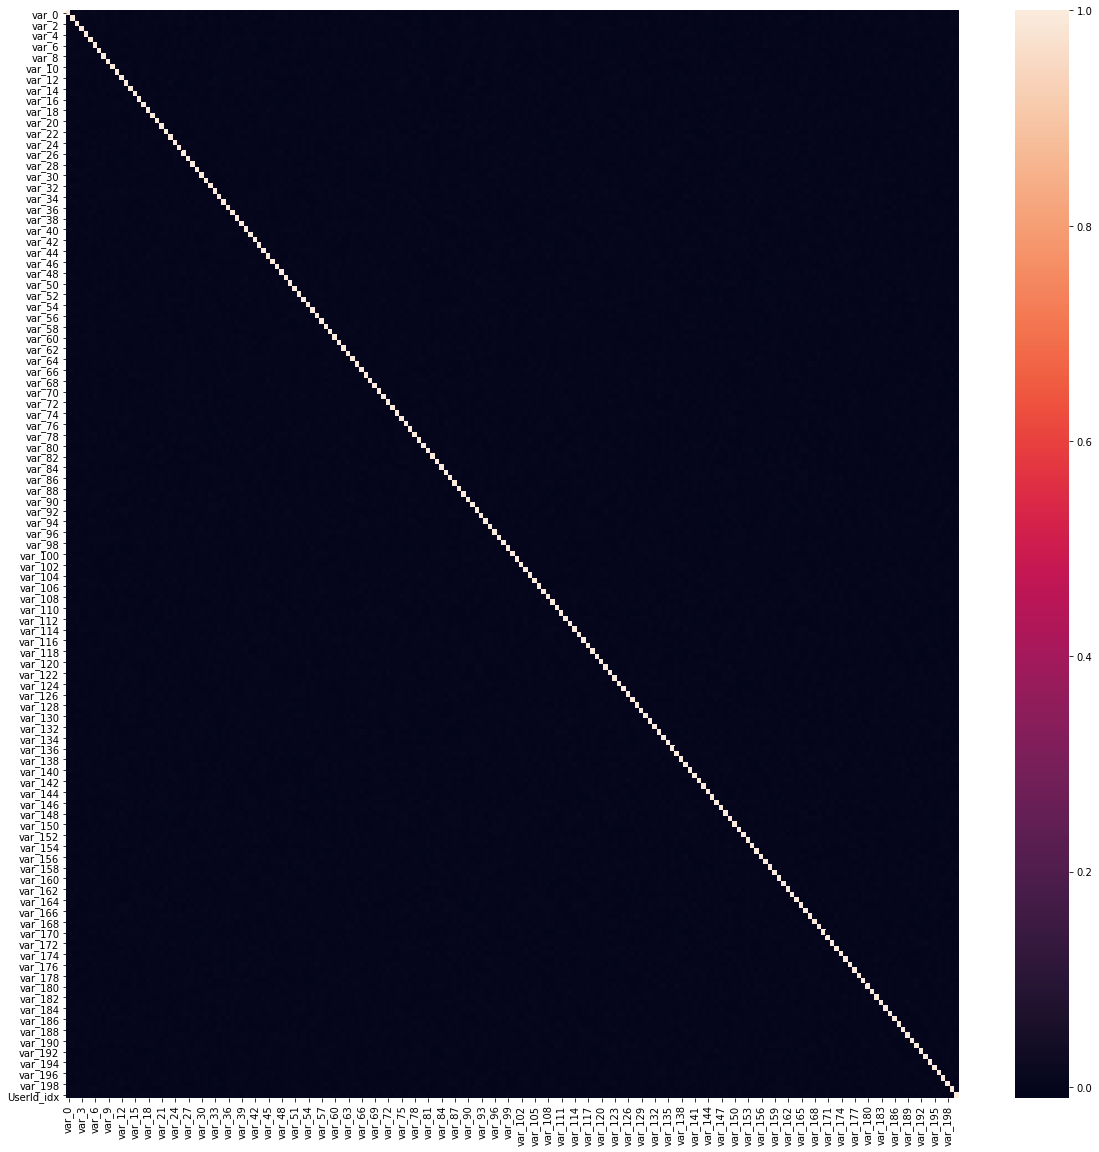

In [23]:
## Check for correlated features 
plt.rcParams['figure.figsize'] = (20, 20)
sns.heatmap(df_crm.corr())

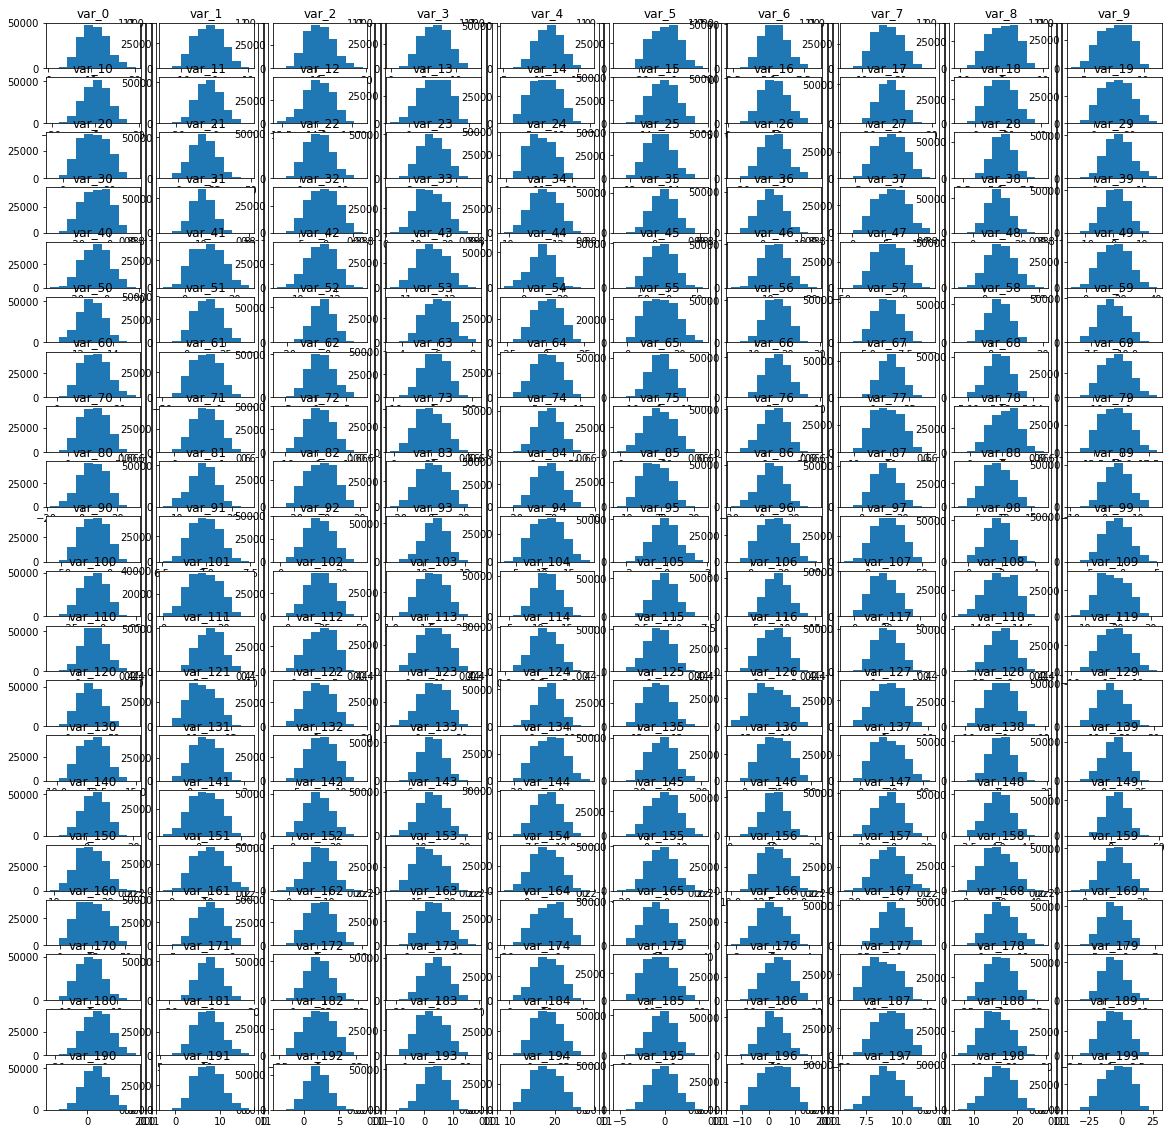

In [24]:
## Check distribution
feature_cols = ['var_%s' %(i) for i in range(0,200)]
plt.figure(figsize=(1000, 1000))

fig, axs = plt.subplots(1, len(feature_cols), sharey=False)

for index, feature in enumerate(feature_cols):
    plt.subplot(20, 10, index+1)
    plt.title(feature)
    plt.hist(df_crm[feature].dropna())

plt.show() 

In [25]:
###############################################################################################
## 2B - Prepare Dataset by Merging df_crm with df (Part-1 fine_food dataset)
###############################################################################################

## Expand Time in df (fine_food dataset)
df['date'] = pd.to_datetime(df['Time'], unit='s')
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['dayofweek'] = pd.DatetimeIndex(df['date']).dayofweek
# df['hour'] = pd.DatetimeIndex(df['date']).hour  ## all 00:00

print (df.year.unique())
print (df.month.unique())
print (df.dayofweek.unique())

df[['UserId_idx', 'ProductId_idx', 'Score', 'Time', 'date', 'year', 'month', 'day', 'dayofweek']].head(1)

[2011 2012 2008 2005 2010 2009 2006 2007 2004 2000 2003 2002 2001 1999]
[ 4  9  8  6 10  7  5 11  2  3 12  1]
[2 4 0 6 3 1 5]


,UserId_idx,ProductId_idx,Score,Time,date,year,month,day,dayofweek
0,0,0,5,1303862400,2011-04-27,2011,4,27,2


In [26]:
## Merge df_crm with fine_food dataset to get more features representing Users
df_crm_merge = pd.merge(df_crm, df[['UserId_idx', 'year', 'month', 'dayofweek']],
                                 on='UserId_idx', how='inner')

## Create target column (Generate User Embedding with model from Part-1)
df_crm_merge['target'] = df_crm_merge.UserId_idx.apply(lambda x: np.squeeze(user_emb.predict([x])))

In [27]:
df_crm_merge.to_csv('crm_merge.csv', index=False) ## Save out 

In [28]:
df_crm_merge = pd.read_csv('crm_merge.csv') ## Read back 

In [29]:
df_crm_merge.head(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_195,var_196,var_197,var_198,var_199,UserId_idx,year,month,dayofweek,target
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,-2.3978,7.8784,8.5635,12.7803,-1.0914,0,2011,4,2,[ 3.3515340e-31 3.4393937e-31 3.3803696e-31 ...
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,2.0339,8.1267,8.7889,18.3560,1.9518,1,2012,9,4,[ 3.4496243e-31 3.4797224e-31 3.3508851e-31 ...
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,3.1417,-6.5213,8.2675,14.7222,0.3965,2,2008,8,0,[ 0.00327265 -0.00167663 -0.00323222 0.003817...
3,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,3.1417,-6.5213,8.2675,14.7222,0.3965,2,2007,8,2,[ 0.00327265 -0.00167663 -0.00323222 0.003817...
4,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,3.1417,-6.5213,8.2675,14.7222,0.3965,2,2012,10,4,[ 0.00327265 -0.00167663 -0.00323222 0.003817...


In [30]:
df_crm_merge.tail(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_195,var_196,var_197,var_198,var_199,UserId_idx,year,month,dayofweek,target
508382,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,5.6669,...,-1.7939,2.1661,8.5326,16.6660,-17.8661,199995,2012,9,3,[ 1.12781909e-05 1.16402705e-04 -6.69714839e-...
508383,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,6.0019,...,1.7337,-2.1651,6.7419,15.9054,0.3388,199996,2012,3,5,[ 2.9599415e-03 -3.0910100e-03 2.8972097e-03 ...
508384,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,6.1629,...,-1.5736,1.2832,8.7155,13.8329,4.1995,199997,2010,11,6,[-0.003641 -0.00369434 -0.00361552 0.001665...
508385,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,8.7542,...,-0.0786,6.7980,10.0342,15.5289,-13.9001,199998,2011,10,6,[ 1.39056574e-05 1.05472503e-03 1.29284555e-...
508386,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,-0.4541,9.3688,...,-2.4907,-2.2342,8.1857,12.1284,0.1385,199999,2011,3,5,[-0.00157765 -0.00277376 -0.00227619 -0.002836...


In [31]:
## Check for Null value again
print (df_crm_merge.isnull().any().any())

False


In [32]:
from ast import literal_eval

In [33]:
df_crm_merge.loc[:,'target'] = df_crm_merge.loc[:,'target'].apply(lambda x: literal_eval( ','.join(x.replace('[ ', '[').split())))

In [34]:
###################################################################
# 2C - Train NN (Embedding Vector Prediction model for New User)
###################################################################

## Parameters
np.random.seed = 42
batch_sizes = 64
num_epochs = 30


#### Train Test Split data
X = df_crm_merge.drop(columns=['target', 'UserId_idx']).astype(float)
y = df_crm_merge['target']
y = np.stack(y.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## Define NN layer
X_input = Input(shape=(X_train.T.shape[0],), dtype='float32', name='X_input')
X = Flatten()(X_input)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(1024, activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(50, activation='linear')(X)        ## y_train.T.shape[0]  is 50           
emb_model_newuser = Model(inputs=X_input, outputs=X)                    


## Define loss and optimizer
emb_model_newuser.compile(loss='mse', optimizer=Adam(0.001))

emb_model_newuser.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 203)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 203)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               52224     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
__________

In [35]:
## Train Model
emb_model_newuser.fit(X_train, y_train, batch_size=batch_sizes, epochs=num_epochs, 
          validation_data=(X_test, y_test), verbose=1)


Train on 406709 samples, validate on 101678 samples
Epoch 1/30
406709/406709 [==============================] - 22s 55us/step - loss: 4.1298 - val_loss: 1.1245e-04
Epoch 2/30
406709/406709 [==============================] - 22s 55us/step - loss: 7.9201e-04 - val_loss: 1.2329e-04
Epoch 3/30
406709/406709 [==============================] - 22s 55us/step - loss: 0.0012 - val_loss: 1.1364e-04
Epoch 4/30
406709/406709 [==============================] - 22s 55us/step - loss: 3.1659e-04 - val_loss: 1.1298e-04
Epoch 5/30
406709/406709 [==============================] - 22s 55us/step - loss: 2.9454e-04 - val_loss: 1.1254e-04
Epoch 6/30
406709/406709 [==============================] - 22s 54us/step - loss: 1.8525e-04 - val_loss: 1.1263e-04
Epoch 7/30
406709/406709 [==============================] - 22s 55us/step - loss: 1.3732e-04 - val_loss: 1.1269e-04
Epoch 8/30
406709/406709 [==============================] - 22s 55us/step - loss: 1.1729e-04 - val_loss: 1.1293e-04
Epoch 9/30
406709/406709 [==

In [36]:
####################
## 2D - Save Model
####################
emb_model_newuser.save('trained_model_newuser_embed.h5')

In [37]:
emb_model_newuser = load_model('trained_model_newuser_embed.h5')

In [38]:
########################################################################################################
## 2D - Transfer Pretrained Weights from Part-1 NN to a modified NN (Recommender model for New User)
########################################################################################################

## Define NN layer
product_embedding_input = Input(shape=(50,), dtype='float32', name='product_embedding_input')
user_embedding_input = Input(shape=(50,), dtype='float32', name='user_embedding_input')
concat = Concatenate()([user_embedding_input, product_embedding_input])
X = Flatten()(concat)
X = Dense(256, activation='relu')(X) ##1
X = Dropout(0.3)(X)
X = Dense(512, activation='relu')(X) ##2
X = Dropout(0.3)(X)
X = Dense(1024, activation='relu')(X) ##3
X = Dropout(0.3)(X)
X = Dense(64, activation='relu')(X) ##4
X = Dropout(0.5)(X)
X = Dense(1, activation='linear')(X)                       
recommender_model_NU = Model(inputs=[user_embedding_input, product_embedding_input], outputs=X)

recommender_model_NU.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_embedding_input (InputLaye (None, 50)           0                                            
__________________________________________________________________________________________________
product_embedding_input (InputL (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 100)          0           user_embedding_input[0][0]       
                                                                 product_embedding_input[0][0]    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           concatenate_1[0][0]              
__________

In [39]:
## Load Weights from Part-1 pre-trained model
for i in range (5,len(recommender_model_NU.layers)):
    recommender_model_NU.layers[i].set_weights(recommender_model_EU.layers[i+2].get_weights())

In [40]:
####################
## 2E - Save Model
####################
recommender_model_NU.save('trained_model_recoNU.h5')

In [41]:
recommender_model_NU = load_model('trained_model_recoNU.h5')

In [42]:
def get_rating_for_new_user(new_user_crm, productId, selectTop=10, user_embedding_model = None, product_embedding_model = None, recommender_model = None):
    '''
    Input
    new_user_crm:  203 dimensions vector of user
    productId: int for product id
    user_embedding_model: convert 203 dim user vector to a 50 dim embedding vector
    product_embedding_model: convert productId to a 50 dim embedding vector
    recommender_model: take in user and product embedding vectors and return a score
    Output
    rating for a product
    '''
    
    if not user_embedding_model or not product_embedding_model or not recommender_model:
        print ("Please input THREE models: user_embedding model, product_embedding_model, recommender_model ")
        return
    
    ## Generate Product embedding (from Part-1)
    product_embedding_vec = np.squeeze(product_emb.predict([productId]), axis=0)

    ## Predict New User embedding vector
    user_embedding_vec = user_embedding_model.predict(np.expand_dims(new_user_crm, axis=0))

    ## Predict Rating for ALL products. 
    rating = recommender_model.predict([user_embedding_vec, product_embedding_vec])
   
    return float(rating.flatten())
    

### Result:
** <b> Top-10 ProductIDs to recommed to New User </b> based on similarity of the embedding vector (predicted using new user's CRM data) with the existing user. <br>


In [43]:
## Example: a new User CRM to generate Top-10 product to recommend
new_user_crm = X_test.iloc[0].values

## Create dataframe for Top-500 Products dataframe
df['ProductId_idx'] = df.apply(lambda x: productid2idx[x.ProductId], axis=1)
df_product_top500 = df.groupby(['ProductId', 'ProductId_idx']).agg({'Score': 'mean'})\
                            .nlargest(500, 'Score').reset_index(drop=False).drop(columns=['Score'])

## Add new column for New User
df_product_top500['UserId'] = str('NEW_USER')
df_product_top500.head()

,ProductId,ProductId_idx,UserId
0,141278509X,67356,NEW_USER
1,2841233731,39961,NEW_USER
2,9376674501,19637,NEW_USER
3,B00002Z754,272,NEW_USER
4,B0000535LF,34978,NEW_USER


In [44]:
df_product_top500['predicted_rating'] = df_product_top500.apply(lambda x: get_rating_for_new_user(new_user_crm, x['ProductId_idx'],user_embedding_model=emb_model_newuser, 
                        product_embedding_model=product_emb, recommender_model=recommender_model_NU), axis=1)

In [45]:
df_product_top500.nlargest(10, 'predicted_rating').reset_index()

,index,ProductId,ProductId_idx,UserId,predicted_rating
0,310,B0000DG5AG,4787,NEW_USER,4.085819
1,369,B0000DIYIN,70991,NEW_USER,4.052835
2,309,B0000DG5AE,4788,NEW_USER,4.050018
3,281,B0000DF3M8,70279,NEW_USER,4.030277
4,118,B0000CEOKH,7357,NEW_USER,3.973625
5,313,B0000DG5AO,4794,NEW_USER,3.957539
6,167,B0000CNU3J,58535,NEW_USER,3.947351
7,388,B0000DK63L,28130,NEW_USER,3.943852
8,486,B0000GHEF8,45090,NEW_USER,3.933789
9,463,B0000GG25Q,62060,NEW_USER,3.887828


### Remarks: Above models require optimization with hyperparameter tuning.

## ------------------- The END -------------------